In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix

from rich import print
from rich.console import Console

console = Console()

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Assuming you have a dataset object named 'dataset'
# Apply transformations to the dataset
root_dir = '/kaggle/input/asl-alphabet-train/asl_alphabet_train'
datasets = datasets.ImageFolder(root=root_dir, transform=transform)

In [3]:
# Split the dataset into train, test, and validation sets
dataset_split = [0.7, 0.15, 0.15]
train_data, val_data, test_data = torch.utils.data.random_split(datasets,
                                    [round(p * len(datasets)) for p in dataset_split],
                                    generator=torch.Generator().manual_seed(42))

print(f"Final Training data size: {len(train_data)}")
print(f"Final Validation Dataset size: {len(val_data)}")
print(f"Final Test Dataset size: {len(test_data)}")

Final Training data size: 60900

Final Validation Dataset size: 13050

Final Test Dataset size: 13050

In [4]:
# Define batch size for train, validation, and test sets
batch_size_train = 64
batch_size_val = 32
batch_size_test = 32

# Define data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_test)

# If you have a GPU available, you can use it for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Import SqueezeNet from torchvision.models
import torchvision.models as models

# Load pre-trained SqueezeNet model
model = models.squeezenet1_0(pretrained=True).to(device)

# Replace the last fully connected layer with a new one for the desired number of classes
num_classes = len(datasets.classes)
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)).to(device)

In [7]:
# Freeze all layers except the fully connected layer
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[1].parameters():
    param.requires_grad = True

In [8]:
# Wrap the model with DataParallel to run on multiple GPUs if available
model = nn.DataParallel(model)

print(f"Device: {device}")
print(f"Model: {model}")

Device: cuda

Model: DataParallel(
  (module): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (5): Fire(
        (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (7): Fire(
        (squeeze): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (8): Fire(
        (squeeze): Conv2d(256, 48, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (9): Fire(
        (squeeze): Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (10): Fire(
        (squeeze): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (12): Fire(
        (squeeze): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Conv2d(512, 29, kernel_size=(1, 1), stride=(1, 1))
      (2): ReLU(inplace=True)
      (3): AdaptiveAvgPool2d(output_size=(1, 1))
    )
  )
)

In [9]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=1):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_train_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_loss = running_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
# Initialize the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=1)

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_accuracy = correct_test / total_test
print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

Epoch [1/1], Train Loss: 0.5940, Train Acc: 0.8819, Val Loss: 0.1522, Val Acc: 0.9780

Test Loss: 0.1588, Test Acc: 0.9754

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Assuming you have a dataset object named 'test_dataset'
# Apply transformations to the test dataset
root_dir = '/kaggle/input/test-data'
test_dataset = datasets.ImageFolder(root=root_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# Initialize empty lists to store test labels and predictions
test_labels = []
test_predictions = []

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        
        # Append test labels and predictions to the lists
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct_test / total_test
print("Final External Test Dataset Results: ")
print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Convert lists to arrays
test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

Final External Test Dataset Results:

Test Loss: 3.9853, Test Acc: 0.2996

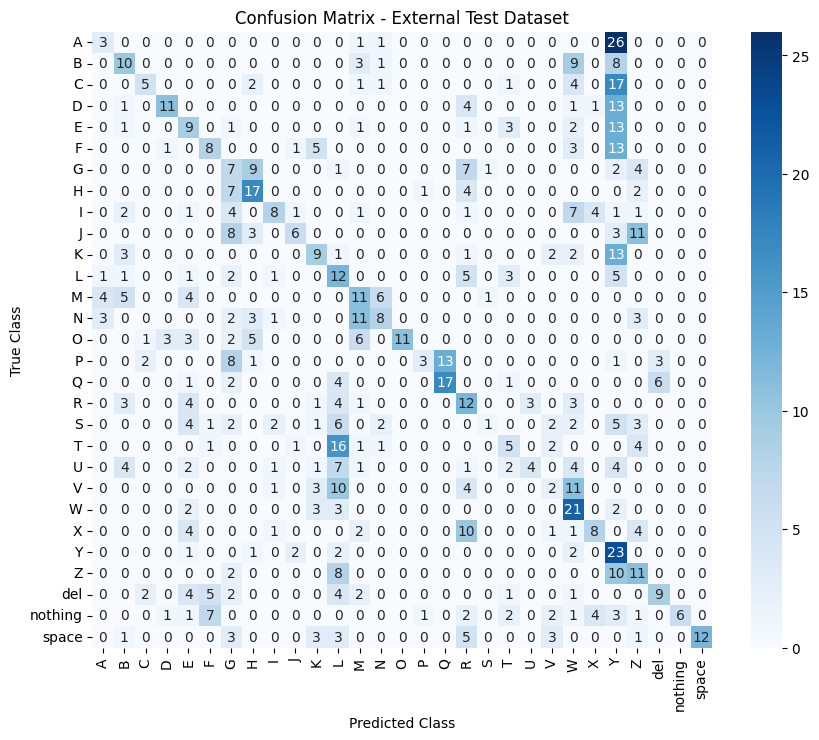

In [18]:
# Generate confusion matrix for the fine-tuned model
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix for the fine-tuned model
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix - External Test Dataset")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()